<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
push!(LOAD_PATH, ".")
using RobustOptimization
using Ipopt, JuMP, PyPlot
using ScikitLearn
@sk_import model_selection: train_test_split
@sk_import metrics: roc_curve
@sk_import metrics: roc_auc_score
@sk_import metrics: accuracy_score
@sk_import metrics: classification_report
path_train = "datasets/ionosphere_scale"
nbfeatures = 34
data_train = read_data_libsvm(path_train, nbfeatures);
# xtr, xte, ytr, yte = train_test_split(data_train[:,1:end-1], data_train[:,end], train_size = 0.15)
# ab_train = hcat(xtr, ytr)
# aux_train = ab_train[ab_train[:,end] .< 0,:]
# ll_train = vcat(aux_train,data_train[data_train[:,end].>0,:])

rs = 75
xtr, xte, ytr, yte = train_test_split(data_train[:,1:end-1], data_train[:,end], train_size = 0.6, random_state = rs)
df_train = hcat(xtr, ytr)
# low_train = hcat(xtr, ytr)
df_aux= hcat(xte, yte);

In [2]:
# df_train, df_aux = create_data("diabetes_scale", nbfeatures, 0.2, train_test_split)
solver = IpoptSolver(print_level = 2)
N = size(df_train)[1]
ϵ = 0.05
verbosity = 500
itmax = 10000
sample = N

ambiguity = "KLdivergence"
robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
α = 1/norm(robustModel.descent_direction)
# α = 0.1
projParams = ProjParams(Int(40), 1e-5, sample, para_proj=Sequential(), para_inter=Sequential())
optParams = OptParams(itmax, 1e-5, α, verbosity = verbosity);

In [3]:
xnormal = normal_opt(df_train, solver, robustModel.regressionModel)
fpr, tpr, thresholds = roc_curve(df_aux[:,end], positive_rate(xnormal,df_aux))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



([0.0, 0.0192308, 0.153846, 0.153846, 0.173077, 0.173077, 0.192308, 0.192308, 0.211538, 0.211538  …  0.480769, 0.5, 0.5, 0.519231, 0.519231, 0.538462, 0.538462, 0.557692, 0.557692, 1.0], [0.0, 0.0, 0.0, 0.0449438, 0.0449438, 0.0898876, 0.0898876, 0.213483, 0.213483, 0.314607  …  0.955056, 0.955056, 0.966292, 0.966292, 0.977528, 0.977528, 0.988764, 0.988764, 1.0, 1.0], [2.0, 1.0, 1.0, 0.999992, 0.999991, 0.999973, 0.999972, 0.999794, 0.999733, 0.998022  …  0.536114, 0.391011, 0.358508, 0.350994, 0.245074, 0.202028, 0.198651, 0.0562994, 0.0522239, 1.06549e-23])

In [4]:
e_tab = [0.0001,0.0005,0.0006,0.0007,0.0008,0.0009,
            0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,
            0.01,0.05,0.1,0.5]
e_plot = [1,2,7,11,16,17,18]
# e_tab = [0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.05,0.1,0.5,1.0]

7-element Array{Int64,1}:
  1
  2
  7
 11
 16
 17
 18

In [20]:
dm_tab = []
time_tab = []
xr1_tab = []
xr2_tab = []
fpr1_tab = []
tpr1_tab = []
fpr2_tab = []
tpr2_tab = []
for ϵ in e_tab
    println(" ")
    println("espilon = ", ϵ)
    println(" ")
    robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
    x0 = initialize(df_train, robustModel, KLConstraint())
    xalg, yalg, dm, mem, mini, t_iter = run_algo(x0, df_train, robustModel, optParams, projParams)
    xrobust1 = getsolution(xalg, ambiguity, nbfeatures)
    xrobust2 = getsolution(mem, ambiguity, nbfeatures)
    fpr1, tpr1, thresholds = roc_curve(df_aux[:,end], positive_rate(xrobust1,df_aux))
    fpr2, tpr2, thresholds = roc_curve(df_aux[:,end], positive_rate(xrobust2,df_aux))
    push!(time_tab, t_iter)
    push!(dm_tab, dm)
    push!(xr1_tab, xrobust1)
    push!(xr2_tab, xrobust2)
    push!(fpr1_tab, fpr1)
    push!(tpr1_tab, tpr1)
    push!(fpr2_tab, fpr2)
    push!(tpr2_tab, tpr2)
end

 
espilon = 0.0001
 
500 0.03997732544919952 1000 0.028729831878568923 1500 0.02380124270041506 2000 0.020567928256423063 2500 0.01842679976181838 3000 0.01688702694286892 3500 0.015704216947227234 4000 0.014781897643430852 4500 0.014062541129253425 5000 0.013474921848775523 5500 0.012989516477049268 6000 0.012572464400742334 6500 0.012208609262868375 7000 0.011871577804784206 7500 0.011570005438811481 8000 0.01129833625977561 8500 0.011045678903999434 9000 0.010815050016902639 9500 0.010604630539244653 10000 0.010409923790902553  
espilon = 0.0005
 
500 0.03989090962345854 1000 0.028960479440693465 1500 0.024292454064628988 2000 0.021226276648013798 2500 0.01911211853689876 3000 0.01759181257363185 3500 0.016455811845493606 4000 0.01555562892911766 4500 0.014835664835005868 5000 0.014248783034824353 5500 0.01374176586214837 6000 0.01329474936461672 6500 0.012896265951507502 7000 0.012534931813252381 7500 0.012206157981205834 8000 0.011908022031807963 8500 0.011636393606789142 9000 0.0

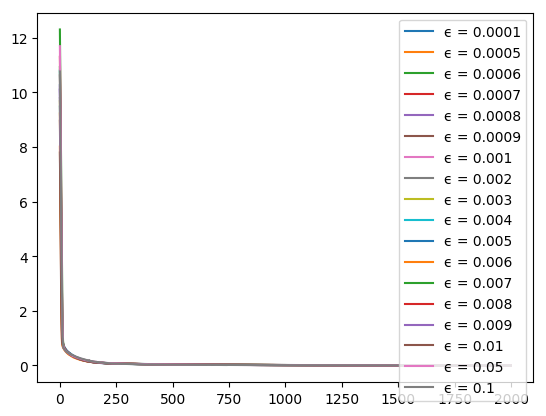

PyObject <matplotlib.legend.Legend object at 0x7fb6771bc240>

In [12]:
for i in 1:(size(e_tab)[1]-1)
    plot(dm_tab[i][1:2000]-dm_tab[i][2000], label="ϵ = $(e_tab[i])")
end
legend()

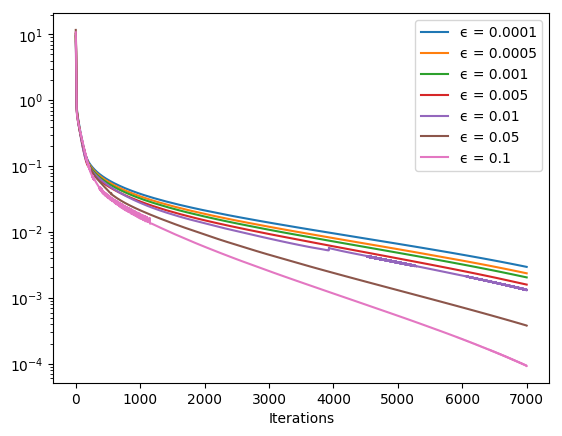

PyObject <matplotlib.legend.Legend object at 0x7f8103ddb588>

In [8]:
for i in e_plot
    plot(dm_tab[i][1:7000]-dm_tab[i][end], label="ϵ = $(e_tab[i])")
    yscale("log")
end
xlabel("Iterations")
legend()

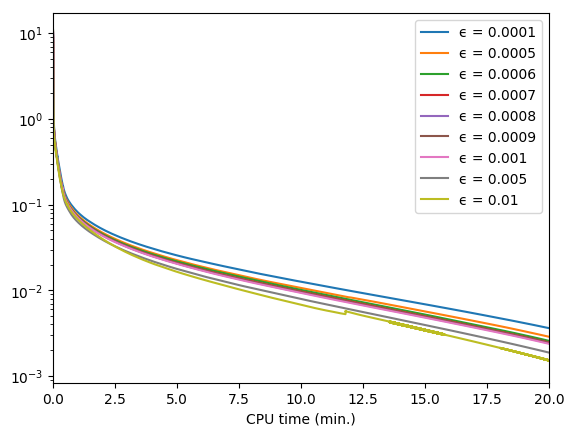

PyObject <matplotlib.legend.Legend object at 0x7f3c4bbe6cc0>

In [20]:
for i in e_plot
    plot(cumsum(time_tab[i])[1:7000]/60, dm_tab[i][1:7000]-dm_tab[i][end], label="ϵ = $(e_tab[i])")
    yscale("log")
end
xlabel("CPU time (min.)")
xlim(0.00,20)
legend(loc=1)

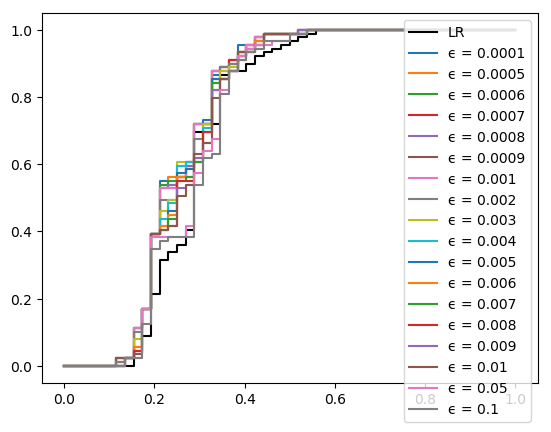

PyObject <matplotlib.legend.Legend object at 0x7fcc99cb7e48>

In [31]:
plot(fpr,tpr, color="black", label="LR")
for i in 1:(size(e_tab)[1]-1)
     plot(fpr1_tab[i], tpr1_tab[i], label="ϵ = $(e_tab[i])")
end
legend()

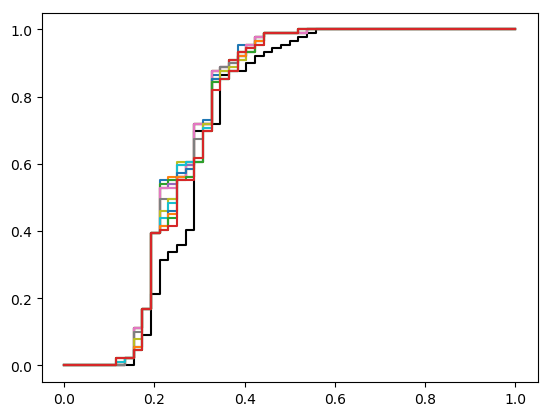

In [25]:
plot(fpr,tpr, color="black")
for i in 1:14
     plot(fpr2_tab[i], tpr2_tab[i])
end

0.7134831460674158  0.7943262411347518
0.7474070872947277  0.8226950354609929
0.7474070872947277  0.8226950354609929
0.747191011235955  0.8226950354609929
0.7467588591184097  0.8226950354609929
0.746542783059637  0.8226950354609929
0.746542783059637  0.8226950354609929
0.7463267070008642  0.8226950354609929
0.7439498703543648  0.8226950354609929
0.7415730337078652  0.8226950354609929
0.7394122731201382  0.8226950354609929
0.7376836646499567  0.8226950354609929


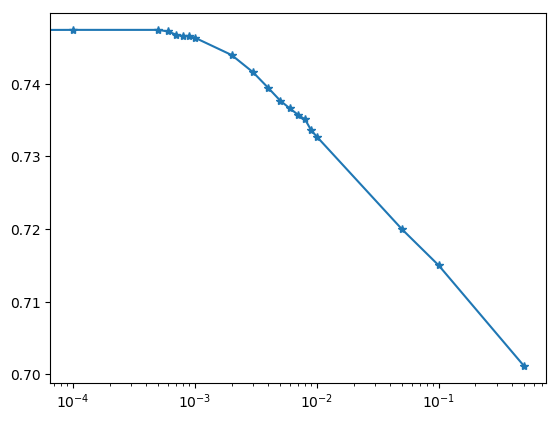

0.7366032843560933  0.8226950354609929
0.7357389801210026  0.8156028368794326
0.7350907519446845  0.8156028368794326
0.7335782195332756  0.8085106382978723
0.732713915298185  0.8085106382978723
0.7199654278305964  0.8085106382978723
0.7149956784788245  0.8085106382978723
0.7011668107173725  0.7943262411347518


In [38]:
plt_AUC = []
print(roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
push!(plt_AUC,roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
print("  ")
println(accuracy_score(df_aux[:,end], pred(df_aux, xnormal, LogisticRegression())))
for i in 1:(size(e_tab)[1])
    push!(plt_AUC, roc_auc_score(df_aux[:,end], positive_rate(xr1_tab[i],df_aux)))
    print(roc_auc_score(df_aux[:,end], positive_rate(xr1_tab[i],df_aux)))
    print("  ")
    println(accuracy_score(df_aux[:,end], pred(df_aux, xr1_tab[i], LogisticRegression())))
end
plot(vcat([0],e_tab),plt_AUC, marker="*")
xscale("log")

0.7134831460674158  0.7943262411347518


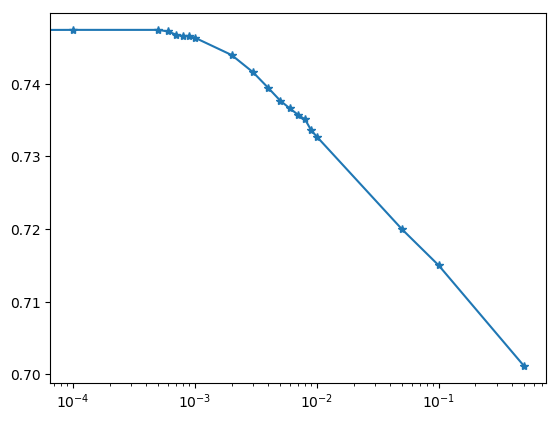

0.7474070872947277  0.8226950354609929
0.7474070872947277  0.8226950354609929
0.747191011235955  0.8226950354609929
0.7467588591184097  0.8226950354609929
0.746542783059637  0.8226950354609929
0.746542783059637  0.8226950354609929
0.7463267070008642  0.8226950354609929
0.7439498703543648  0.8226950354609929
0.7415730337078652  0.8226950354609929
0.7394122731201382  0.8226950354609929
0.7376836646499567  0.8226950354609929
0.7366032843560933  0.8226950354609929
0.7357389801210026  0.8156028368794326
0.7350907519446845  0.8156028368794326
0.7335782195332756  0.8085106382978723
0.732713915298185  0.8085106382978723
0.7199654278305964  0.8085106382978723
0.7149956784788245  0.8085106382978723
0.7011668107173725  0.7730496453900709


In [39]:
plt_AUC = []
print(roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
push!(plt_AUC,roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
print("  ")
println(accuracy_score(df_aux[:,end], pred(df_aux, xnormal, LogisticRegression())))
for i in 1:(size(e_tab)[1])
    push!(plt_AUC, roc_auc_score(df_aux[:,end], positive_rate(xr1_tab[i],df_aux)))
    print(roc_auc_score(df_aux[:,end], positive_rate(xr2_tab[i],df_aux)))
    print("  ")
    println(accuracy_score(df_aux[:,end], pred(df_aux, xr2_tab[i], LogisticRegression())))
end
plot(vcat([0],e_tab),plt_AUC, marker="*")
xscale("log")

In [12]:
# @everywhere df_train, df_aux = create_data("diabetes_scale", nbfeatures, 0.7, train_test_split)
solver = IpoptSolver(print_level = 2)
N = size(df_train)[1]
ϵ = 0.05
verbosity = 1
itmax = 100
sample = 1500

ambiguity = "wasserstein"
robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
α = 1/norm(robustModel.descent_direction)
# α = 1.0
projParams = ProjParams(Int(400), 1e-5, sample, para_proj=Sequential(), para_inter=Sequential())
optParams = OptParams(itmax, 1e-5, α, verbosity = verbosity);

In [13]:
xnormal = normal_opt(df_train, solver, robustModel.regressionModel)
fpr, tpr, thresholds = roc_curve(df_aux[:,end], positive_rate(xnormal,df_aux))

([0.0, 0.0192308, 0.153846, 0.153846, 0.173077, 0.173077, 0.192308, 0.192308, 0.211538, 0.211538  …  0.480769, 0.5, 0.5, 0.519231, 0.519231, 0.538462, 0.538462, 0.557692, 0.557692, 1.0], [0.0, 0.0, 0.0, 0.0449438, 0.0449438, 0.0898876, 0.0898876, 0.213483, 0.213483, 0.314607  …  0.955056, 0.955056, 0.966292, 0.966292, 0.977528, 0.977528, 0.988764, 0.988764, 1.0, 1.0], [2.0, 1.0, 1.0, 0.999992, 0.999991, 0.999973, 0.999972, 0.999794, 0.999733, 0.998022  …  0.536114, 0.391011, 0.358508, 0.350994, 0.245074, 0.202028, 0.198651, 0.0562994, 0.0522239, 1.06549e-23])

In [14]:
# e_tab_was = [0.0001]
e_tab_was = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
e_plot = [1,2,3,4,5,6,7,11,16]

9-element Array{Int64,1}:
  1
  2
  3
  4
  5
  6
  7
 11
 16

In [37]:
dm_was = []
time_was = []
xr1_was = []
xr2_was = []
fpr1_was = []
tpr1_was = []
fpr2_was = []
tpr2_was = []
for ϵ in e_tab_was
# for ϵ in [0.001,0.005,0.01]
    println(" ")
    println("espilon = ", ϵ)
    println(" ")
    robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
    x0 = init_proj(df_train, robustModel, projParams);
    xalg, yalg, dm, mem, mini, t_was = run_algo(x0, df_train, robustModel, optParams, projParams)
    xrobust1 = getsolution(xalg, ambiguity, nbfeatures)
    xrobust2 = getsolution(mem, ambiguity, nbfeatures)
    fpr1, tpr1, thresholds = roc_curve(df_aux[:,end], positive_rate(xrobust1,df_aux))
    fpr2, tpr2, thresholds = roc_curve(df_aux[:,end], positive_rate(xrobust2,df_aux))
    push!(dm_was, dm)
    push!(time_was, dm)
    push!(xr1_was, xrobust1)
    push!(xr2_was, xrobust2)
    push!(fpr1_was, fpr1)
    push!(tpr1_was, tpr1)
    push!(fpr2_was, fpr2)
    push!(tpr2_was, tpr2)
end

 
espilon = 0.0001
 
1 0.0 2 0.0 3 0.0 4 0.0 5 0.0 6 0.0 7 0.0 8 0.0 9 0.0 10 0.0 11 0.0 12 0.0 13 0.0 14 7.66119487988215e-9 15 0.0 16 0.0 17 0.0 18 0.0 19 0.0020422278757254997 20 0.0 21 0.0016515811369405275 22 0.0002078385501800839 23 0.059570530874219374 24 0.020810145289044013 25 0.03276078582425024 26 0.0 27 0.0019080320935659922 28 0.0025931141993920104 29 0.0015064752789532565 30 0.0006991588674447614 31 0.011911355087840025 32 0.004925086788076877 33 0.0018385888865726833 34 0.0016453872811104941 35 7.677317188953259e-6 36 2.8833762385472488e-5 37 0.015174768029284413 38 0.0 39 0.0 40 0.0020564633356182985 41 0.0012027463626363786 42 0.04921820890130224 43 0.0 44 0.003122349962909707 45 0.0 46 4.482882430399682e-6 47 0.0 48 0.0 49 0.0 50 2.781783496320217e-6 51 0.00506626777684227 52 8.448540065104926e-6 53 0.0 54 0.03065853342272251 55 0.0 56 0.0 57 0.008405680943573246 58 0.009554862837186318 59 0.0 60 3.6250853566038854e-6 61 0.001454027747297082 62 0.0023940443474486095 6

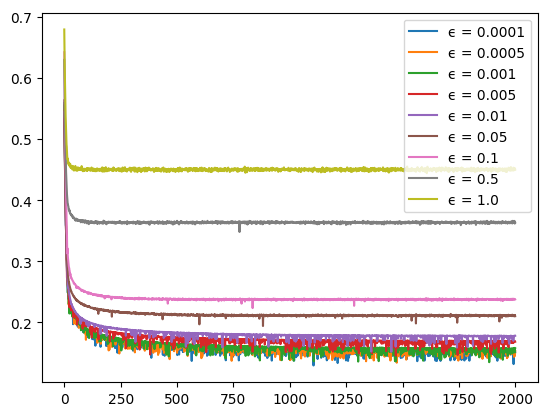

PyObject <matplotlib.legend.Legend object at 0x7f243112d6d8>

In [14]:
for i in e_plot
     plot(dm_was[i], label="ϵ = $(e_tab_was[i])")
end
legend()

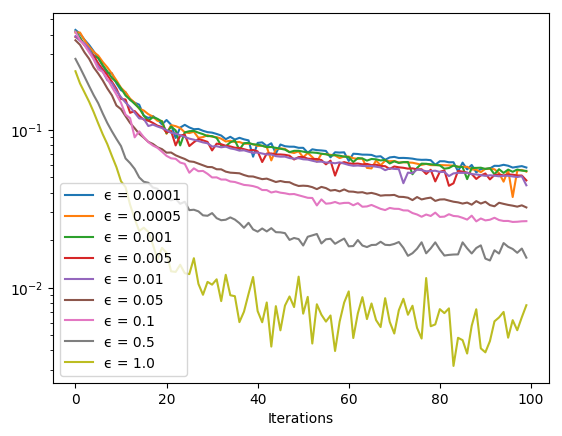

PyObject <matplotlib.legend.Legend object at 0x7f80fdfb34a8>

In [13]:
for i in e_plot
    plot((dm_was[i][1:100]-minimum(dm_was[i])), label="ϵ = $(e_tab_was[i])")
    yscale("log")
end
xlabel("Iterations")
legend()

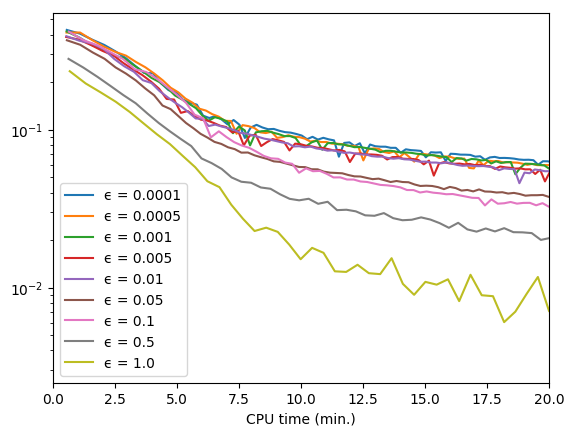

PyObject <matplotlib.legend.Legend object at 0x7f3c4bfbf438>

In [17]:
for i in e_plot
    plot(cumsum(time_was[i][1:100]), (dm_was[i][1:100]-minimum(dm_was[i])), label="ϵ = $(e_tab_was[i])")
    yscale("log")
end
xlabel("CPU time (min.)")
xlim(0,20)
legend()

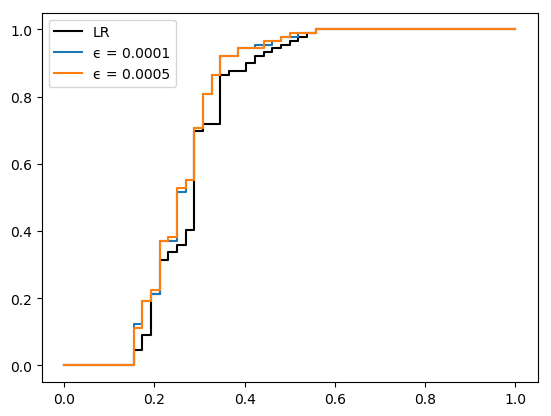

PyObject <matplotlib.legend.Legend object at 0x7f6af04a2400>

In [170]:
plot(fpr,tpr, color="black", label="LR")
for i in 1:size(e_tab_was)[1]
     plot(fpr1_was[i], tpr1_was[i], label="ϵ = $(e_tab[i])")
end
legend()

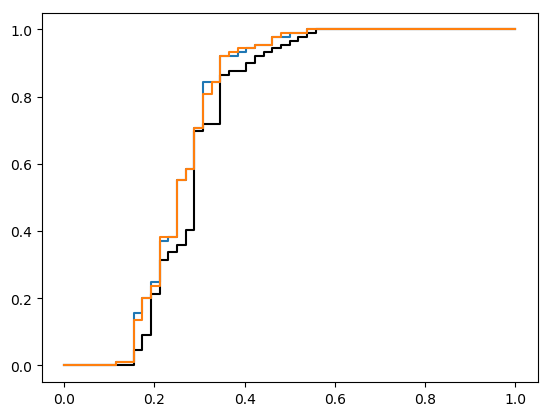

In [171]:
plot(fpr,tpr, color="black")
for i in 1:size(e_tab_was)[1]
     plot(fpr2_was[i], tpr2_was[i])
end

In [172]:
# Montrer pour différente de taille de dataset et regarder à partir de quel moment la méthode de base décroche

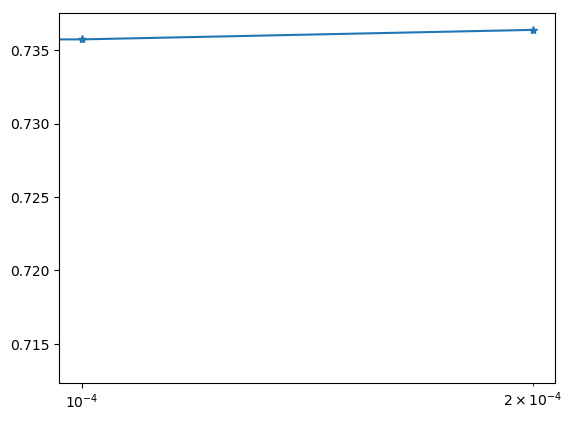

0.7134831460674158  0.7943262411347518
0.7357389801210026  0.8085106382978723
0.7363872082973206  0.8014184397163121


In [173]:
plt_was = []
print(roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
push!(plt_was, roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
print("  ")
println(accuracy_score(df_aux[:,end], pred(df_aux, xnormal, LogisticRegression())))
for i in 1:size(e_tab_was)[1]
    print(roc_auc_score(df_aux[:,end], positive_rate(xr1_was[i],df_aux)))
    push!(plt_was, roc_auc_score(df_aux[:,end], positive_rate(xr1_was[i],df_aux)))
    print("  ")
    println(accuracy_score(df_aux[:,end], pred(df_aux, xr1_was[i], LogisticRegression())))
end
plot(vcat([0],e_tab_was),plt_was, marker="*")
xscale("log")

In [174]:
print(roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
print("  ")
println(accuracy_score(df_aux[:,end], pred(df_aux, xnormal, LogisticRegression())))
for i in 1:21
    print(roc_auc_score(df_aux[:,end], positive_rate(xr2_was[i],df_aux)))
    print("  ")
    println(accuracy_score(df_aux[:,end], pred(df_aux, xr2_was[i], LogisticRegression())))
end

0.7134831460674158  0.7943262411347518
0.7398444252376837  0.8014184397163121
0.7394122731201382  0.8014184397163121


LoadError: [91mBoundsError: attempt to access 2-element Array{Any,1} at index [3][39m

In [175]:
println(classification_report(df_aux[:,end], pred(df_aux, xnormal, LogisticRegression())))
println(classification_report(df_aux[:,end], pred(df_aux, xr1_was[3], LogisticRegression())))

             precision    recall  f1-score   support

       -1.0       0.87      0.52      0.65        52
        1.0       0.77      0.96      0.85        89

avg / total       0.81      0.79      0.78       141



LoadError: [91mBoundsError: attempt to access 2-element Array{Any,1} at index [3][39m

In [176]:
open("io-log-was.txt", "w") do f
    write(f, "xnormal = ")
    write(f, "$xnormal \n")
#     write(f, "fpr = ")
#     write(f, "$fpr \n")
#     write(f, "tpr = ")
#     write(f, "$tpr \n")
#     write(f, "dm_tab = ")
#     write(f, "$dm_tab \n")
#     write(f, "time_tab = ")
#     write(f, "$time_tab \n")
#     write(f, "xr1_tab = ")
#     write(f, "$xr1_tab \n")
#     write(f, "fpr1_tab = ")
#     write(f, "$fpr1_tab \n")
#     write(f, "tpr1_tab = ")
#     write(f, "$tpr1_tab \n")
    write(f, "dm_was = ")
    write(f, "$dm_was \n")
    write(f, "time_was = ")
    write(f, "$time_was \n")
    write(f, "xr1_was = ")
    write(f, "$xr1_was \n")
    write(f, "fpr1_was = ")
    write(f, "$fpr1_was \n")
    write(f, "tpr1_was = ")
    write(f, "$tpr1_was \n")
end

651